In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections as cl
import scipy as sp
import pandas as pd

In [2]:
import json
from pandas.io.json import json_normalize
import networkx as nx

js = open('friends.json')
js = js.read()
data = json.loads(js)

In [3]:
j = 0
result = {}
r = []
covered = [1] * len(data['nodes'])
while j < len(data['links']):
    i = data['links'][j]['target']
    while (j < len(data['links'])) and (i == data['links'][j]['target']):
        r.append(data['nodes'][data['links'][j]['source']]['name'])
        j += 1
    result[data['nodes'][i]['name']] = tuple(r)
    covered[i] = 0
    r = []
for i in range(len(data['nodes'])):
    if (covered[i]): result[data['nodes'][i]['name']] = ()

In [4]:
G = nx.from_dict_of_lists(result)
n = len(G.nodes())
e = len(G.edges())
print('Nodes:', n)
print('Edges:', e)

Nodes: 357
Edges: 3740


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


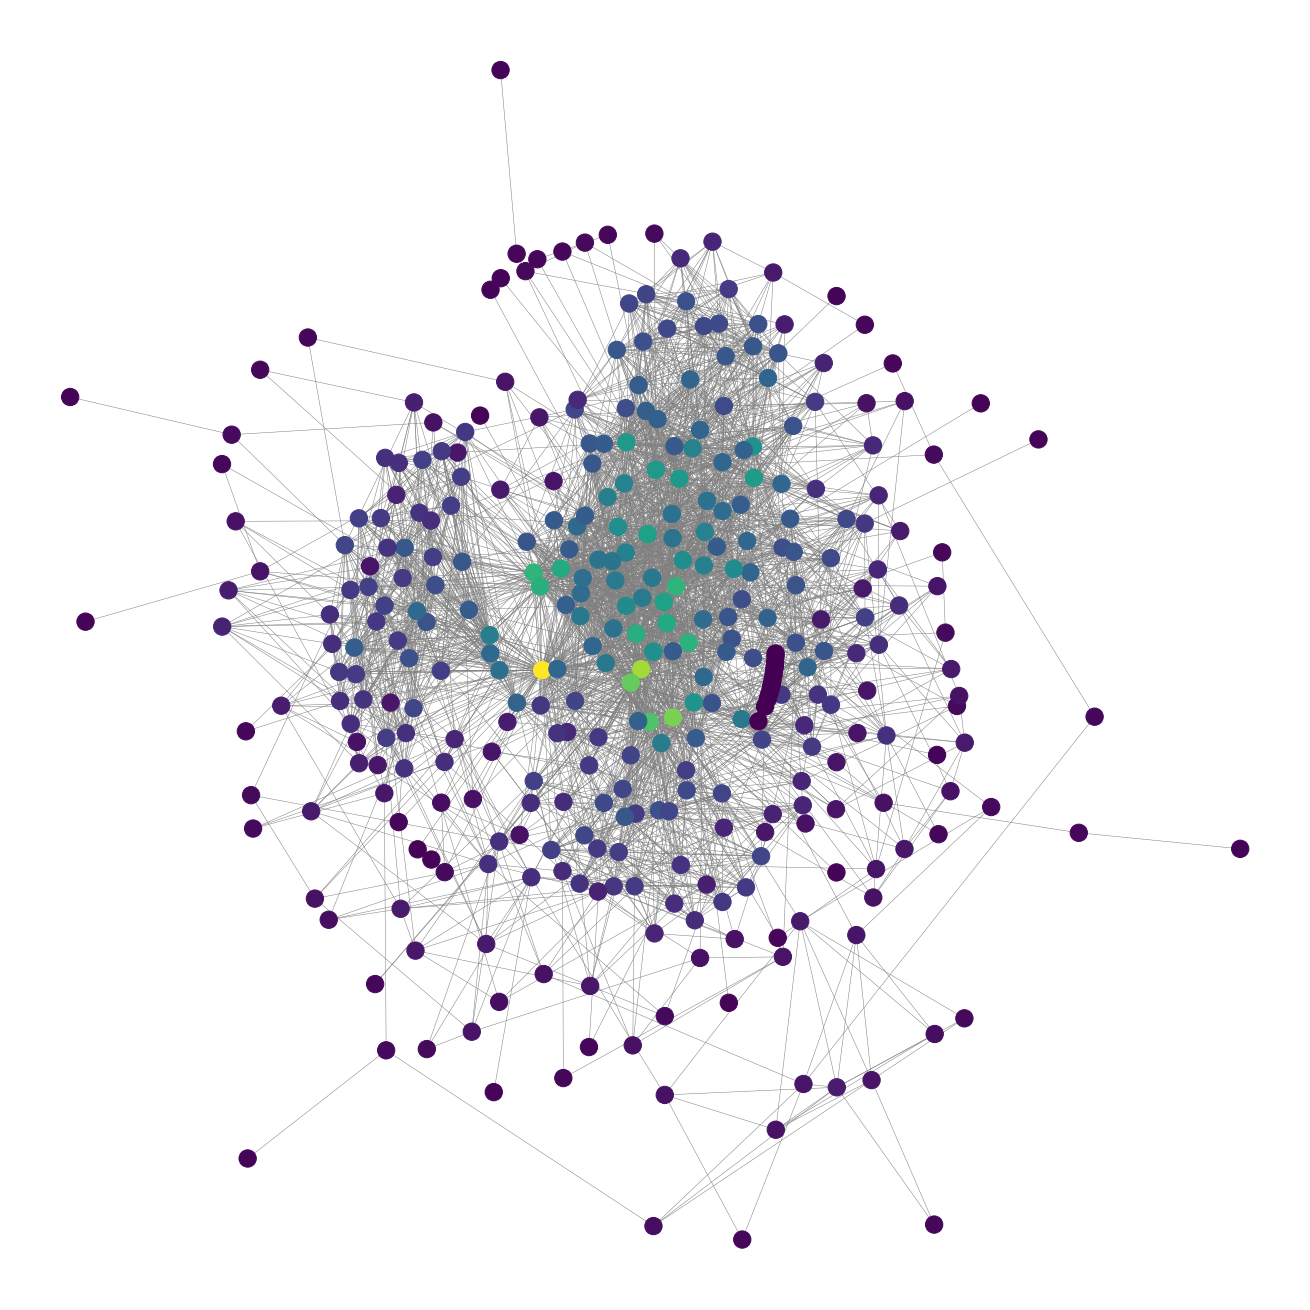

In [5]:
degree = nx.degree_centrality(G)

nx.set_node_attributes(G, degree, "degree")

deg = np.array(list(nx.get_node_attributes(G, "degree").values())).astype(dtype=float)

plt.figure(figsize=(18,18))
nx.draw_kamada_kawai(G, node_color=deg, width=0.5, edge_color='gray', font_size=11)

In [9]:
def _process_params(G, center, dim):
    import numpy as np

    if not isinstance(G, nx.Graph):
        empty_graph = nx.Graph()
        empty_graph.add_nodes_from(G)
        G = empty_graph

    if center is None:
        center = np.zeros(dim)
    else:
        center = np.asarray(center)

    if len(center) != dim:
        msg = "length of center coordinates must match dimension of layout"
        raise ValueError(msg)

    return G, center

In [17]:
from scipy.optimize import minimize

def _kamada_kawai_solve(dist_mtx, pos_arr, dim):
    meanwt = 1e-3
    costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3),
                meanwt, dim)

    optresult = minimize(_kamada_kawai_costfn, pos_arr.ravel(),
                         method='L-BFGS-B', args=costargs, jac=True)

    return optresult.x.reshape((-1, dim))

def _kamada_kawai_costfn(pos_vec, np, invdist, meanweight, dim):
    nNodes = invdist.shape[0]
    pos_arr = pos_vec.reshape((nNodes, dim))

    delta = pos_arr[:, np.newaxis, :] - pos_arr[np.newaxis, :, :]
    nodesep = np.linalg.norm(delta, axis=-1)
    direction = np.einsum('ijk,ij->ijk',
                          delta,
                          1 / (nodesep + np.eye(nNodes) * 1e-3))

    offset = nodesep * invdist - 1.0
    offset[np.diag_indices(nNodes)] = 0

    cost = 0.5 * np.sum(offset ** 2)
    grad = (np.einsum('ij,ij,ijk->ik', invdist, offset, direction) -
            np.einsum('ij,ij,ijk->jk', invdist, offset, direction))

    sumpos = np.sum(pos_arr, axis=0)
    cost += 0.5 * meanweight * np.sum(sumpos ** 2)
    grad += meanweight * sumpos

    return (cost, grad.ravel())

In [20]:
def kamada_kawai_layout_alg(G, dist=None,
                        pos=None,
                        weight='weight',
                        scale=1,
                        center=None,
                        dim=2):
    G, center = _process_params(G, center, dim)
    nNodes = len(G)
    if nNodes == 0:
        return {}

    if dist is None:
        dist = dict(nx.shortest_path_length(G, weight=weight))
    dist_mtx = 1e6 * np.ones((nNodes, nNodes))
    for row, nr in enumerate(G):
        if nr not in dist:
            continue
        rdist = dist[nr]
        for col, nc in enumerate(G):
            if nc not in rdist:
                continue
            dist_mtx[row][col] = rdist[nc]

    if pos is None:
        if dim >= 3:
            pos = random_layout(G, dim=dim)
        elif dim == 2:
            pos = nx.circular_layout(G, dim=dim)
        else:
            pos = {n: pt for n, pt in zip(G, np.linspace(0, 1, len(G)))}
    pos_arr = np.array([pos[n] for n in G])

    pos = _kamada_kawai_solve(dist_mtx, pos_arr, dim)

    pos = nx.rescale_layout(pos, scale=scale) + center
    return dict(zip(G, pos))

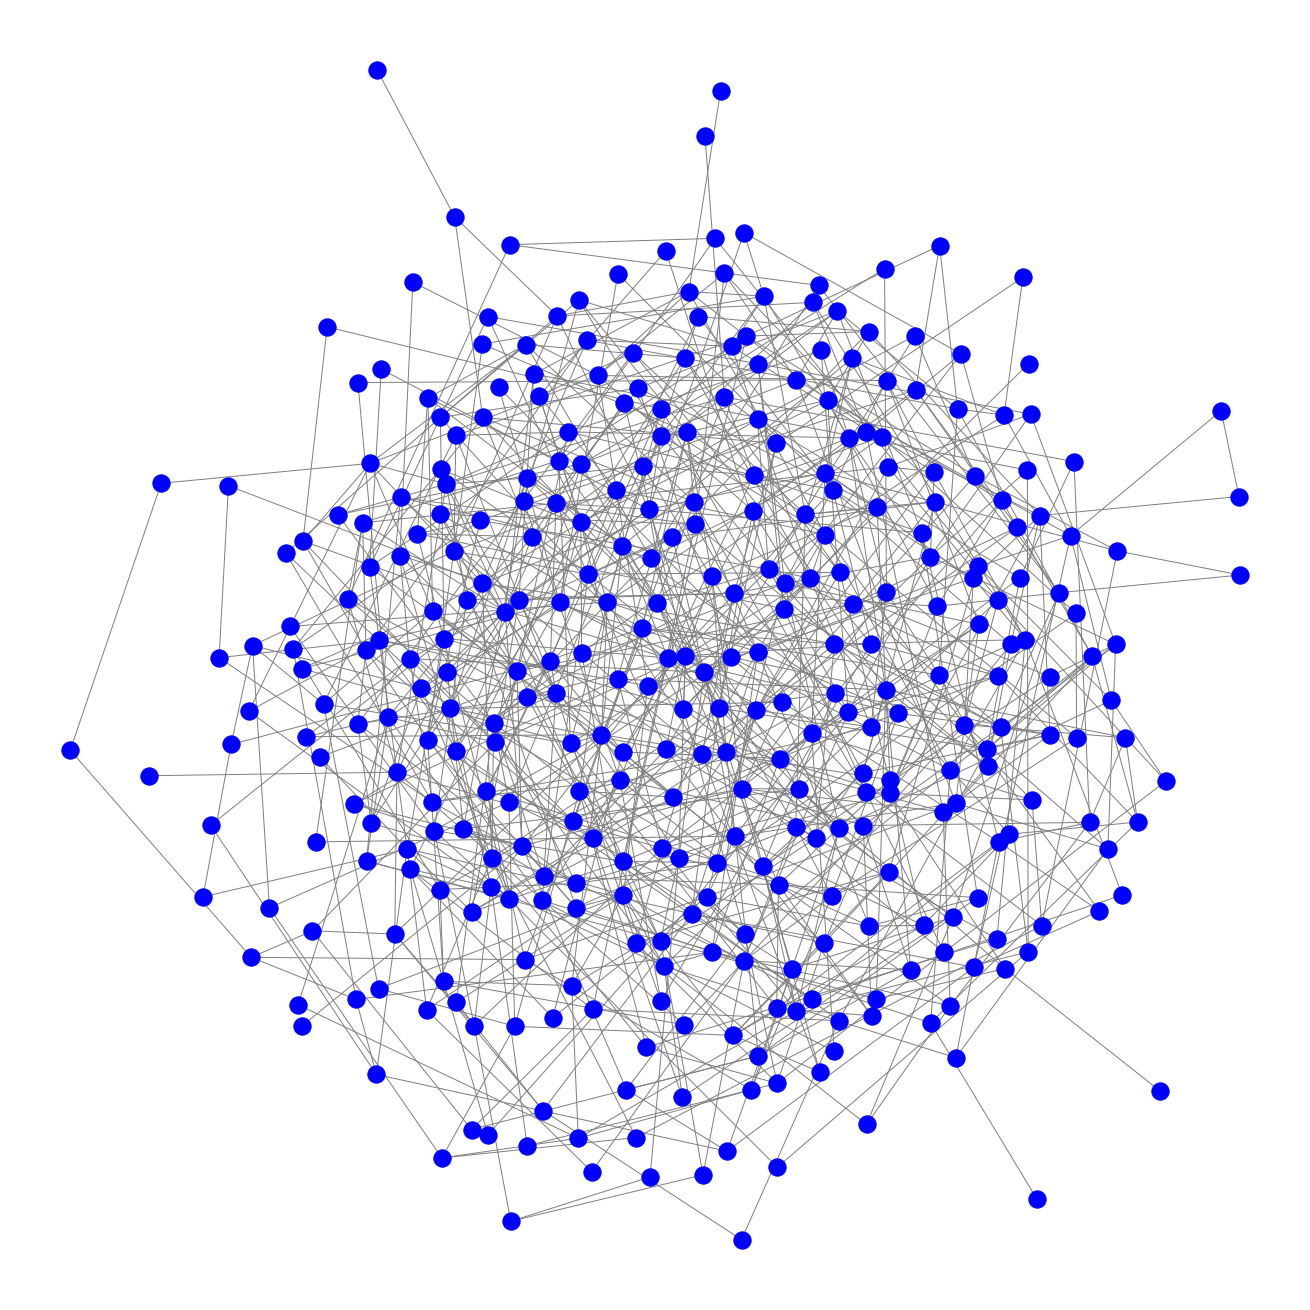

In [21]:
prob = e / (n * (n - 1)) / 2
GG = nx.gnp_random_graph(n, prob)
    
pos=kamada_kawai_layout_alg(GG)

plt.figure(figsize=(18,18))
nx.draw(GG, pos, node_color = 'blue', edge_color = 'gray')
plt.show()

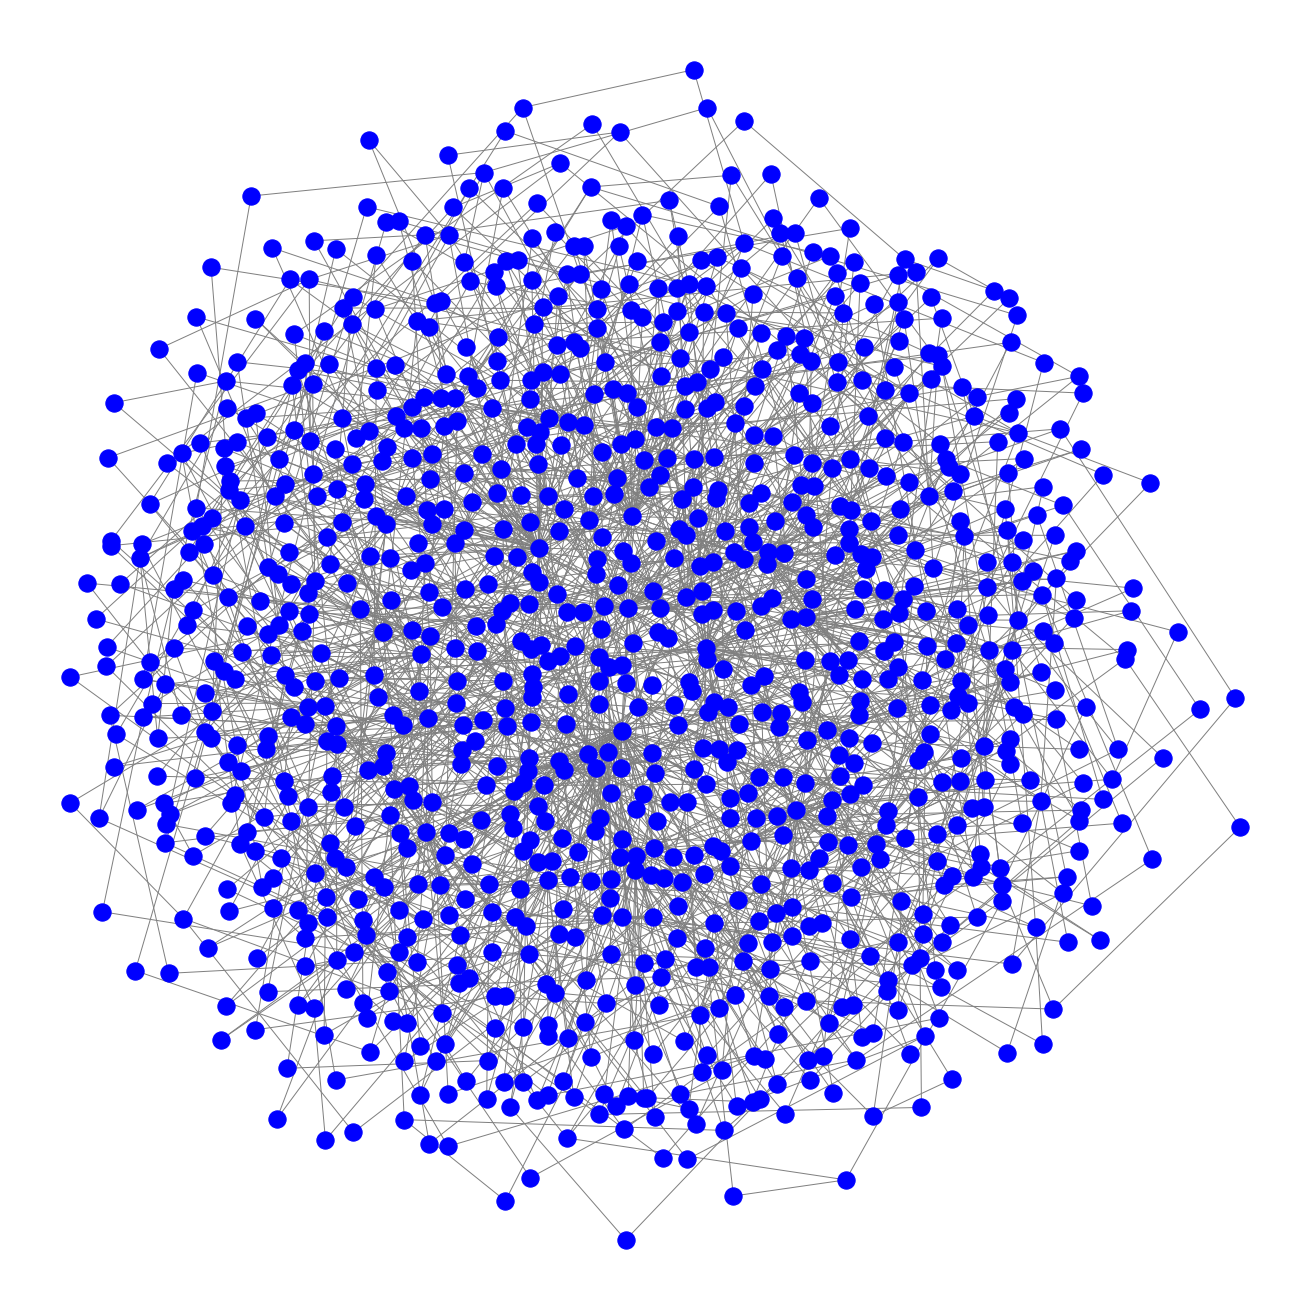

In [23]:
nn = 1000
mm = 2
GG = nx.generators.barabasi_albert_graph(nn, mm)

pos = kamada_kawai_layout_alg(GG)

plt.figure(figsize=(18,18))
nx.draw(GG, pos, node_color = 'blue', edge_color = 'gray')
plt.show()

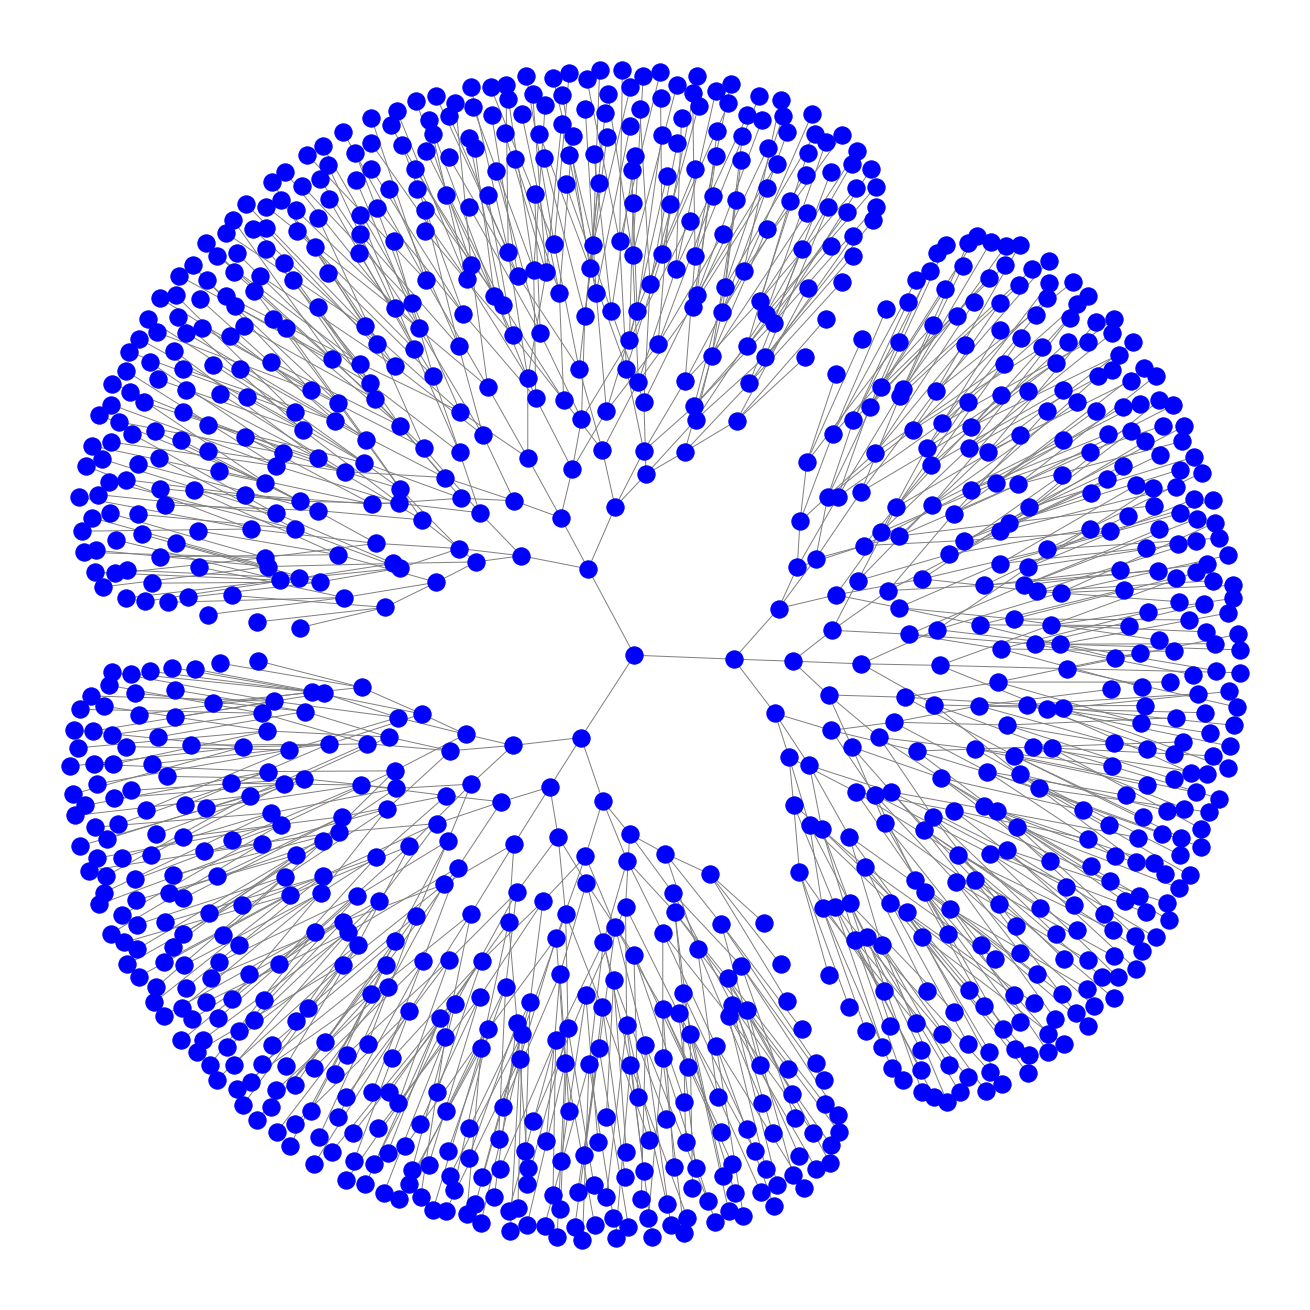

In [24]:
GG = nx.balanced_tree(3, 6)
pos = kamada_kawai_layout_alg(GG)

plt.figure(figsize=(18,18))
nx.draw(GG, pos, node_color = 'blue', edge_color = 'gray')
plt.show()